# Inference
Predict using full candidate data as input, and explain outputs with SHAP explainer.

In [3]:
import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interact
from joblib import load
from shap import Explanation, plots
from tqdm.auto import trange

In [4]:
# Load the pickled model
with open('../sCJDSurvEnsemble.model', 'rb') as file:
    ensemble = load(file)

## Interactive Inference Interface

In [3]:
# Custom function for candidate data
def candidate(
    sex, ageonset, codon129,
    csfprot, rtquic, csf1433, s100b,
    mriimp, bg, thalamus, cortical, EEG,
    myoclonus, visual, cerebellar, pyramidal, expyramidal,
    akinetic_mutism, cognitive, psychiatric, behave
): 
    args = {
        'sex': sex, 'ageonset': ageonset, 'codon129': codon129,
        'csfprot': csfprot, 'rtquic': rtquic, 'csf1433': csf1433, 's100b': s100b,
        'mriimp':mriimp, 'bg': bg, 'thalamus': thalamus, 'cortical': cortical, 'EEG': EEG,
        'myoclonus': myoclonus, 'visual': visual, 'cerebellar': cerebellar, 'pyramidal': pyramidal, 'expyramidal': expyramidal,
        'akinetic_mutism': akinetic_mutism, 'cognitive': cognitive, 'psychiatric': psychiatric, 'behave': behave
    }
    
    # Give data global scope
    global data
    
    data = pd.Series(args)

    binary_feats = ['bg', 'thalamus', 'myoclonus', 'visual', 'cerebellar',
                    'pyramidal', 'expyramidal', 'akinetic_mutism', 'cognitive',
                    'psychiatric', 'behave']

    # Replace boolean values with Y/N to match original data
    binary_data = data[binary_feats]
    binary_data.replace(True, 'Y', inplace=True)
    binary_data.replace(False, 'N', inplace=True)
    data.drop(binary_feats, inplace=True)
    data = pd.concat([data, binary_data])
    data = pd.DataFrame(data).T
    
    # Set continuous columns as float
    data[['ageonset','s100b', 'cortical', 'csfprot']] = data[['ageonset','s100b', 'cortical', 'csfprot']].astype('float64')

# Interactive Dropdown
result = interact(
    candidate,
    sex=['Male', 'Female'],
    ageonset=(18,100,1),
    codon129=['MM', 'MV', 'VV'],
    csfprot=(0,1,0.01),
    rtquic=['POS', 'NEG'],
    csf1433=['POS', 'NEG'],
    s100b=(0,10,0.01),
    mriimp={'Positive': 'P', 'Suspicious': 'S', 'Negative': 'N'},
    bg=True,
    thalamus=True,
    cortical=(0,10,1),
    EEG=['POS','NEG'],
    myoclonus=True,
    visual=True,
    cerebellar=True,
    pyramidal=True,
    expyramidal=True,
    akinetic_mutism=True,
    cognitive=True,
    psychiatric=True,
    behave=True
);

interactive(children=(Dropdown(description='sex', options=('Male', 'Female'), value='Male'), IntSlider(value=5…

In [4]:
# Predict
surv_dfs = ensemble.predict_surv_df(X=data)
surv_df = ensemble.predict_surv_df(X=data, pool=True)[0]

## Results

In [5]:
# Calculate median survival
median_surv = (surv_df-0.5).abs().sort_values().index[0]
print(f'Median survival: {round(median_surv, 1)} months\n')

# Calculate survival probability at 5 months
surv_prob_5 = surv_df[5]
print(f'Survival probability at 5 months:  {round(surv_prob_5*100, 1)}%')

# Calculate survival probability at 10 months
surv_prob_10 = surv_df[10]
print(f'Survival probability at 10 months: {round(surv_prob_10*100, 1)}%')

# Calculate survival probability at 15 months
surv_prob_15 = surv_df[15]
print(f'Survival probability at 15 months: {round(surv_prob_15*100, 1)}%')

# Calculate survival probability at 20 months
surv_prob_20 = surv_df[20]
print(f'Survival probability at 20 months: {round(surv_prob_20*100, 1)}%')

Median survival: 3.3 months

Survival probability at 5 months:  17.5%
Survival probability at 10 months: 2.7%
Survival probability at 15 months: 0.8%
Survival probability at 20 months: 0.3%


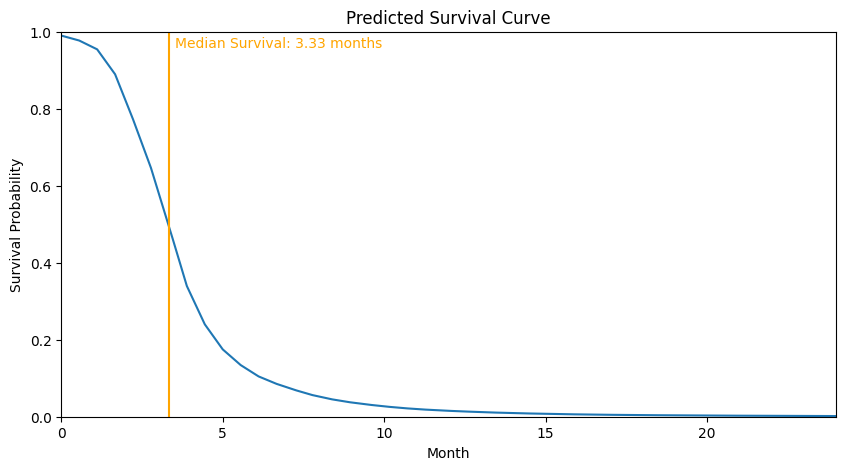

In [6]:
# Survival Curve
plt.figure(figsize=(10,5))

fig = sns.lineplot(
    data=surv_df,
)

fig.set(
    xlabel='Month',
    ylabel='Survival Probability',
    ylim=(0,1),
    xlim=(0,24),
    title='Predicted Survival Curve'
)

# fig.axvline(x=acutal_surv, color='green')
fig.axvline(x=median_surv, color='orange')
fig.text(median_surv+0.2, 0.96, f'Median Survival: {median_surv:.2f} months', color='orange')

plt.show()

## Explanation

In [8]:
# Load pickled explainers
with open('./sCJDSurvModel.explainer', 'rb') as file:
    explainers = load(file)

In [9]:
def explain_scjdsurvmodel(mice_i, candidate):
    
    encoder = explainers[mice_i][0]
    explainer = explainers[mice_i][1]

    # Encode X
    candidate = encoder.transform(candidate)
    
    # explain
    return explainer(candidate)

ensemble_shap = [explain_scjdsurvmodel(mice_i, data) for mice_i in trange(10)]

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
# Pool shap_values across models
shap_values = [pd.DataFrame(ensemble_shap[mice_i].values, columns=ensemble_shap[mice_i].feature_names) for mice_i in range(10)]
shap_values = pd.concat(shap_values)
shap_values = shap_values.groupby(shap_values.index)
shap_values = shap_values.mean()
shap_base_values = [ensemble_shap[mice_i].base_values for mice_i in range(10)]
shap_base_values = np.mean(shap_base_values, axis=0)
shap_data = [pd.DataFrame(ensemble_shap[mice_i].data, columns=ensemble_shap[mice_i].feature_names) for mice_i in range(10)]
shap_data = pd.concat(shap_data)
shap_data = shap_data.groupby(shap_data.index)
shap_data = shap_data.mean().to_numpy()

# Form pooled Explanation object
pooled_shap = Explanation(
    values=shap_values.to_numpy(),
    feature_names=shap_values.columns,
    data=shap_data,
    base_values=shap_base_values
)

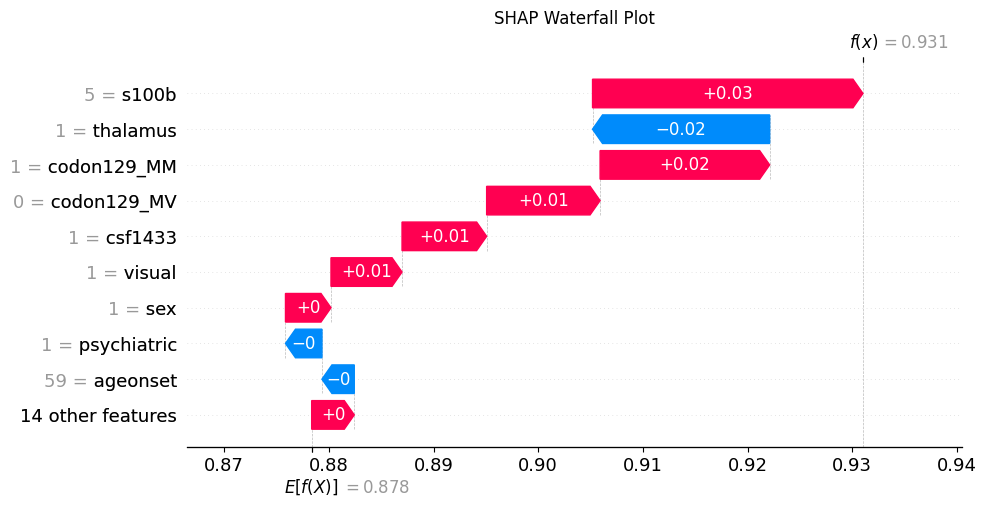

In [11]:
# Visual Waterfall Plot
plots.waterfall(pooled_shap[0], show=False)
plt.title('SHAP Waterfall Plot')
plt.gcf().set_size_inches(10,5)
plt.show()